<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Importing-Required-Packages" data-toc-modified-id="Importing-Required-Packages-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Importing Required Packages</a></span></li><li><span><a href="#Importing-Dataset" data-toc-modified-id="Importing-Dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Importing Dataset</a></span></li><li><span><a href="#Train-Test-Split" data-toc-modified-id="Train-Test-Split-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Train Test Split</a></span></li><li><span><a href="#Exponential-Smoothing-Models" data-toc-modified-id="Exponential-Smoothing-Models-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Exponential Smoothing Models</a></span><ul class="toc-item"><li><span><a href="#Simple-Exponential-Smoothing" data-toc-modified-id="Simple-Exponential-Smoothing-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Simple Exponential Smoothing</a></span></li><li><span><a href="#Double-Exponential-Smoothing-(Trend)" data-toc-modified-id="Double-Exponential-Smoothing-(Trend)-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Double Exponential Smoothing (Trend)</a></span></li><li><span><a href="#Triple-Exponential-Smoothing-(Trend-+-Seasonality)" data-toc-modified-id="Triple-Exponential-Smoothing-(Trend-+-Seasonality)-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Triple Exponential Smoothing (Trend + Seasonality)</a></span></li><li><span><a href="#Accuracy-Comparision" data-toc-modified-id="Accuracy-Comparision-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Accuracy Comparision</a></span></li></ul></li><li><span><a href="#Parameter-Tuning" data-toc-modified-id="Parameter-Tuning-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Parameter Tuning</a></span></li><li><span><a href="#Final-Model" data-toc-modified-id="Final-Model-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Final Model</a></span></li></ul></div>

# Importing Required Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing

from sklearn.metrics import mean_squared_error

import warnings

sns.set()
warnings.filterwarnings("ignore")

# Importing Dataset

In [2]:
file_path = "../data.csv"

In [3]:
data_backup = pd.read_csv(file_path)
data_backup.Date = pd.to_datetime(data_backup.Date)
data_backup.set_index("Date", inplace = True)

In [4]:
data = data_backup[["spx_ret", "spx"]]

# Train Test Split

In [5]:
train_df = data.loc[:"2018-12-31"]
test_df = data.loc["2019-01-01":]

# Exponential Smoothing Models

## Simple Exponential Smoothing

In [6]:
ses_model = SimpleExpSmoothing(train_df["spx_ret"][1:])
ses_model_results = ses_model.fit()

In [7]:
ses_predictions = ses_model_results.predict(start = test_df.index[0], end = test_df.index[-1])

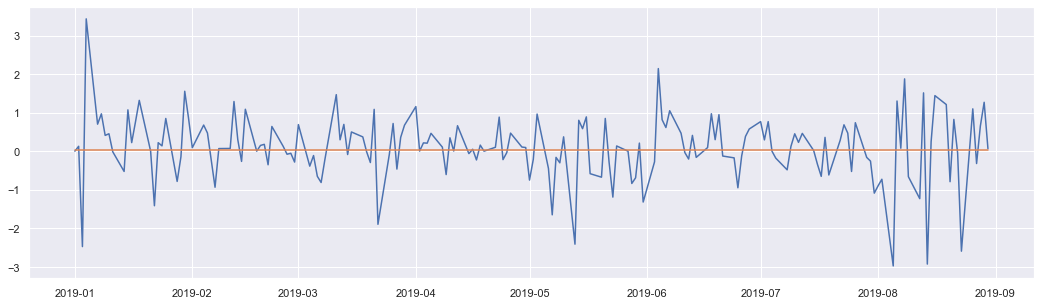

In [8]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(test_df["spx_ret"])
plt.plot(ses_predictions)

plt.show()

## Double Exponential Smoothing (Trend)

In [9]:
des_model = Holt(train_df["spx_ret"][1:], exponential = False, damped_trend = True)
des_model_results = des_model.fit()

In [10]:
des_predictions = des_model_results.predict(start = test_df.index[0], end = test_df.index[-1])

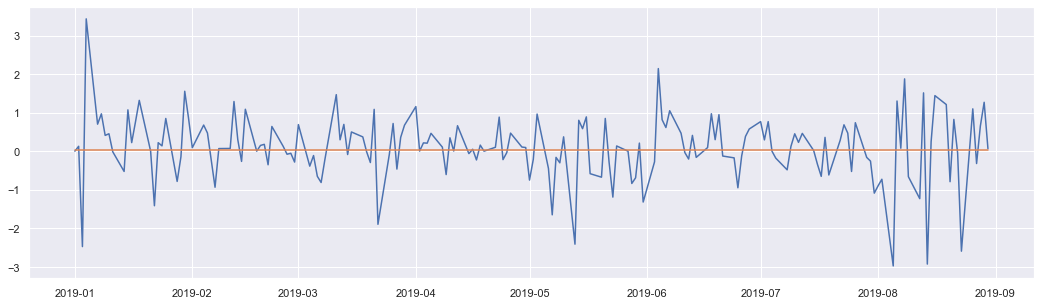

In [11]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(test_df["spx_ret"])
plt.plot(des_predictions)

plt.show()

## Triple Exponential Smoothing (Trend + Seasonality)

In [12]:
tes_model = ExponentialSmoothing(train_df["spx_ret"][1:], 
                                 trend = "add", damped_trend = True,
                                 seasonal = "add", seasonal_periods = 5)
tes_model_results = tes_model.fit()

In [13]:
tes_predictions = tes_model_results.predict(start = test_df.index[0], end = test_df.index[-1])

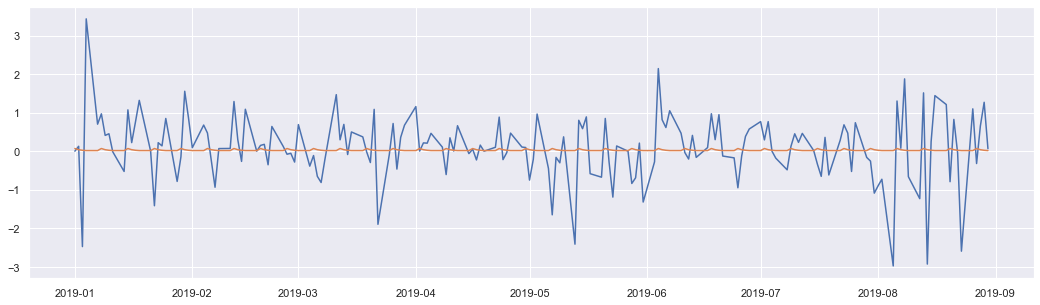

In [14]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(test_df["spx_ret"])
plt.plot(tes_predictions)

plt.show()

## Accuracy Comparision

For this the **Mean Squared Error (MSE)** metric is used.

- **Single Exponential Smoothing**

In [15]:
mean_squared_error(test_df["spx_ret"].values, ses_predictions)

0.7330381374388841

- **Double Exponential Smoothing**

In [16]:
mean_squared_error(test_df["spx_ret"].values, des_predictions)

0.7330779787904137

- **Triple Exponential Smoothing (Holt-Winter's Model)**

In [17]:
mean_squared_error(test_df["spx_ret"].values, tes_predictions)

0.7318052186371219

# Parameter Tuning

These Parameters are **Auto-Tuned** by the model. - 
- smoothing_level ($\alpha$)
- smoothing_slope ($\beta$)
- smoothing_seasonal ($\gamma$)
- damping_slope ($\phi$)

These Parameters are **Tunable** - 
- trend: {“add”, “mul”, None}
- damped: {True, False}
- seasonal: {“add”, “mul”, None}
- seasonal_periods: 5 (according to EDA)
- use_boxcox: {True, False, ‘log’, float} (**'log'** - use log transform, **float** - use the value as $\lambda$)

Using **grid search** we fit models for all these parameters and compare them to find the best one.

In [18]:
def fit_exp_smo_model(train_data, params):
    (t, d, s, sp, u) = params
    model = ExponentialSmoothing(train_data, trend = t, damped = d, seasonal = s, seasonal_periods = sp)
    model_fit = model.fit(optimized = True, use_boxcox = u)
    return model_fit

In [19]:
trend = ["add", "mul", None]
damped = [True, False]
seasonal = ["add", "mul", None]
seasonal_periods = [5]
use_boxcox = [True, False, "log", float]


best_mse = float('inf')

count = 0

for t in trend:
    for d in damped:
        for s in seasonal:
            for sp in seasonal_periods:
                for u in use_boxcox:
                    try:
                        count = count + 1
                        params = (t, d, s, sp, u)
                        model = fit_exp_smo_model(train_df["spx_ret"][1:], params)

                        model_predictions = model.predict(start = test_df.index[0], end = test_df.index[-1])
                        model_mse = mean_squared_error(test_df["spx_ret"].values, model_predictions)

                        if model_mse < best_mse:
                            best_mse = model_mse
                            best_params = params
                    except:
                        continue

**Results of the Grid Search**

- **Number of Models Compared**

In [20]:
count

72

- **Model with the best parameters**

In [21]:
(t, d, s, sp, u) = best_params
print(f"trend - {t}")
print(f"damped - {d}")
print(f"seasonal - {s}")
print(f"seasonal_periods - {sp}")
print(f"use_boxcox - {u}")

trend - add
damped - True
seasonal - add
seasonal_periods - 5
use_boxcox - False


- **Best MSE**

In [22]:
best_mse

0.7318052186371219

# Final Model

The model obtained after parameter tuning is is same as the Model built in the [Triple Expionential Section](#Triple-Exponential-Smoothing-(Trend-+-Seasonality)).

Let's derive the final predictions then.

- **Building Final Model**

In [23]:
final_model = ExponentialSmoothing(train_df["spx_ret"][1:], 
                                 trend = "add", damped_trend = True,
                                 seasonal = "add", seasonal_periods = 5)
final_model_results = final_model.fit()

- **Final Predictions**

In [24]:
final_predictions = final_model_results.predict(start = test_df.index[0], end = test_df.index[-1])

- **Final RMSE**

In [29]:
final_rmse = np.sqrt(mean_squared_error(test_df["spx_ret"].values, final_predictions))

- **Predictions vs Actuals for Holt-Winter's Model**

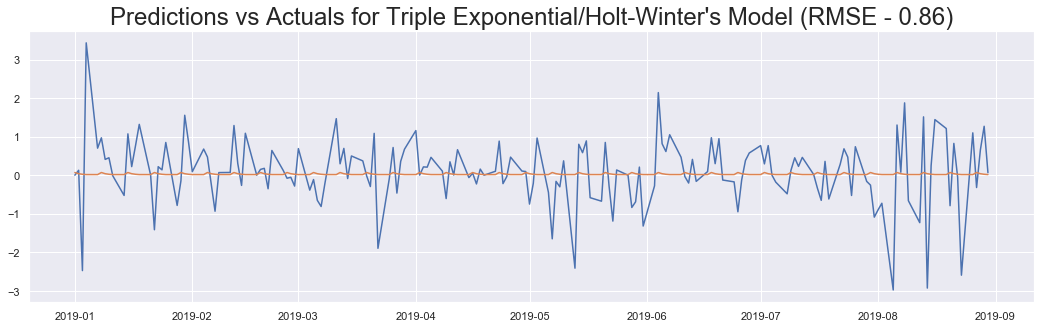

In [31]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(test_df["spx_ret"])
plt.plot(final_predictions)

plt.title(f"Predictions vs Actuals for Triple Exponential/Holt-Winter's Model (RMSE - {round(final_rmse, 2)})", size = 24)

plt.show()